In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

分割函数模块 `_splitter.*` 详解
=================================

### 0. 大纲

分割函数根据数据的稀疏性和阈值遍历方式，细分为四个子类，后面我们一一探究。

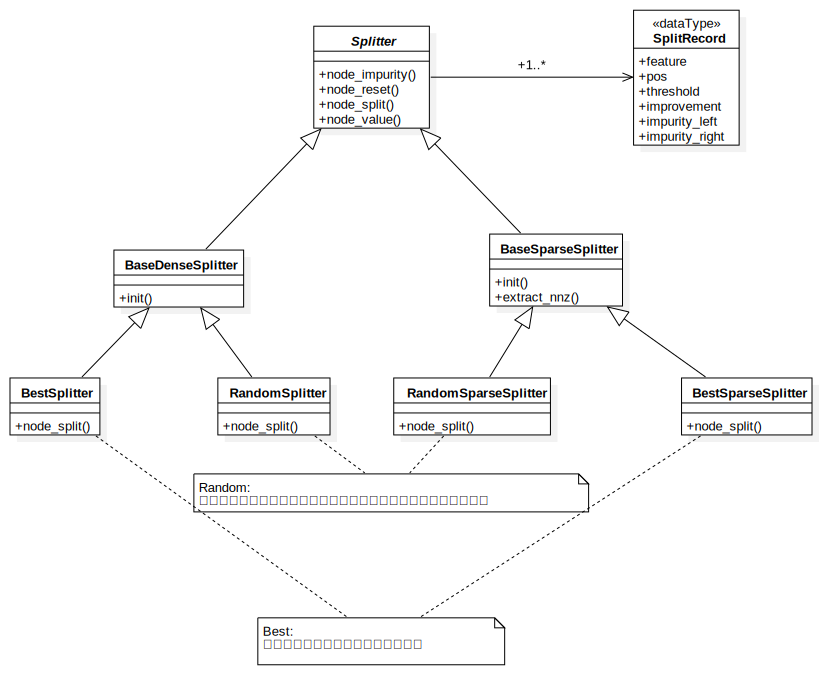

In [2]:
SVG("./res/uml/Model___splitter_2.svg")

### 1. `Splitter`
Splitter 是分割模块的接口类。其定义在 _splitter.pxd 文件，实现在 _splitter.pyx 文件。

为了记录每次分割的情况，首先定义了 SplitRecord 数据结构，含义注释非常清晰，不赘述。

```Python
 23 cdef struct SplitRecord:
 24     # Data to track sample split
 25     SIZE_t feature         # Which feature to split on.
 26     SIZE_t pos             # Split samples array at the given position,
 27                            # i.e. count of samples below threshold for feature.
 28                            # pos is >= end if the node is a leaf.
 29     double threshold       # Threshold to split at.
 30     double improvement     # Impurity improvement given parent node.
 31     double impurity_left   # Impurity of the left split.
 32     double impurity_right  # Impurity of the right split.
```

#### 1.0 内部成员
成员变量粗略分为五部份：

1. 评价函数和终止条件：

   ```Python
 34 cdef class Splitter:
 35 #+--  5 lines: The splitter searches in the input space for a feature and a thresho
 40     # Internal structures
 41     cdef public Criterion criterion      # Impurity criterion
 42     cdef public SIZE_t max_features      # Number of features to test
 43     cdef public SIZE_t min_samples_leaf  # Min samples in a leaf
 44     cdef public double min_weight_leaf   # Minimum weight in a leaf
   ```
  
2. 随机数的种子，在选特征和阈值时会用到：

   ```Python
 46     cdef object random_state             # Random state
 47     cdef UINT32_t rand_r_state           # sklearn_rand_r random number state
   ```
  
3. 样本索引和特征索引：
   + 为了简化交换数据的计算，大量使用了交换索引的思路；
   + 注意 `constant_features`，在有的节点处，某些特征已经是常数（主要是离散特征），不再可分割。为了避免无谓的计算量，sklearn 每次分割会记录下已经是常量的特征，并由父节点到子节点，代代相传。
   
   ```Python
 49     cdef SIZE_t* samples                 # Sample indices in X, y
 50     cdef SIZE_t n_samples                # X.shape[0]
 51     cdef double weighted_n_samples       # Weighted number of samples
 52     cdef SIZE_t* features                # Feature indices in X
 53     cdef SIZE_t* constant_features       # Constant features indices
 54     cdef SIZE_t n_features               # X.shape[1]
 55     cdef DTYPE_t* feature_values         # temp. array holding feature values
   ```
   
4. 节点起止：
   sklearn 将 X 和 y 用数组存储，并在每次分割后，将同一子节点的数据索引归结在一起，所以只需指定首末位罝。
   
   ```Python
 57     cdef SIZE_t start                    # Start position for the current node
 58     cdef SIZE_t end                      # End position for the current node
   ```
   
5. 预排：事先已经有按各特征值排序好的索引矩阵

   ```Python
 60     cdef bint presort                    # Whether to use presorting, only
 61                                          # allowed on dense data
   ```
   
6. 标签和权重

   ```Python
 63     cdef DOUBLE_t* y
 64     cdef SIZE_t y_stride
 65     cdef DOUBLE_t* sample_weight
   ```

#### 1.1 函数方法
##### 1.1.0 `init`

init 是调用时的初始化函数。

```Python
 119     cdef void init(self,
 120                    object X,
 121                    np.ndarray[DOUBLE_t, ndim=2, mode="c"] y,
 122                    DOUBLE_t* sample_weight,
 123                    np.ndarray X_idx_sorted=None) except *:
 124         """Initialize the splitter.
 125 +-- 15 lines: Take in the input data X, the target Y, and optional sample weights
 140         """
 141
 142         self.rand_r_state = self.random_state.randint(0, RAND_R_MAX)
 143         cdef SIZE_t n_samples = X.shape[0]
 144 #+--  3 lines: Create a new array which will be used to store nonzero-------------
 147         cdef SIZE_t* samples = safe_realloc(&self.samples, n_samples)
 148 #+--  5 lines: cdef SIZE_t i, j---------------------------------------------------
 153         for i in range(n_samples):
 154             # Only work with positively weighted samples
 155             if sample_weight == NULL or sample_weight[i] != 0.0:
 156                 samples[j] = i
 157                 j += 1
 158
 159             if sample_weight != NULL:
 160                 weighted_n_samples += sample_weight[i]
 161             else:
 162                 weighted_n_samples += 1.0
 163
 164         # Number of samples is number of positively weighted samples
 165         self.n_samples = j
 166         self.weighted_n_samples = weighted_n_samples
 167
 168         cdef SIZE_t n_features = X.shape[1]
 169         cdef SIZE_t* features = safe_realloc(&self.features, n_features)
 170
 171         for i in range(n_features):
 172             features[i] = i
 173
 174         self.n_features = n_features
 175
 176 #+--  7 lines: safe_realloc(&self.feature_values, n_samples)----------------------
```

主要流程：

1. 142L, 生成随机种子；
2. 143L-166L, 拷贝权重不为零的样本索引，并计算权重总值；
3. 168L-174L, 特征索引；
4. 其它复制准备。


剩下的函数都非常简单，不赘述。

```Python
 88     cdef void node_reset(self, SIZE_t start, SIZE_t end,
 89                          double* weighted_n_node_samples) nogil                    
 90
 91     cdef void node_split(self,
 92                          double impurity,   # Impurity of the node
 93                          SplitRecord* split,
 94                          SIZE_t* n_constant_features) nogil
 95
 96     cdef void node_value(self, double* dest) nogil
 97
 98     cdef double node_impurity(self) nogil
```

### 2. 实阵分割
#### 2.0 `BaseDenseSplitter`
BaseDenseSplitter 增加了关于实阵 X 和相应预排索引的 `X_idx_sorted` 的变量，相应地重载做了初始化工作。

```Python
 232 cdef class BaseDenseSplitter(Splitter):
 233     cdef DTYPE_t* X
 234     cdef SIZE_t X_sample_stride
 235     cdef SIZE_t X_feature_stride
 236
 237     cdef np.ndarray X_idx_sorted
 238     cdef INT32_t* X_idx_sorted_ptr
 239     cdef SIZE_t X_idx_sorted_stride
 240     cdef SIZE_t n_total_samples
 241     cdef SIZE_t* sample_mask
 242
 243 #+-- 16 lines: def __cinit__(self, Criterion criterion, SIZE_t max_features,------
 259
 260     cdef void init(self,
 261                    object X,
 262                    np.ndarray[DOUBLE_t, ndim=2, mode="c"] y,
 263                    DOUBLE_t* sample_weight,
 264                    np.ndarray X_idx_sorted=None) except *:
 265         """Initialize the splitter."""
 266
 267         # Call parent init
 268         Splitter.init(self, X, y, sample_weight)
 269
 270         # Initialize X
 271         cdef np.ndarray X_ndarray = X
 272
 273         self.X = <DTYPE_t*> X_ndarray.data
 274 #+--  2 lines: self.X_sample_stride = <SIZE_t> X.strides[0] / <SIZE_t> X.itemsize-
 276
 277         if self.presort == 1:
 278             self.X_idx_sorted = X_idx_sorted
 279 #+--  4 lines: self.X_idx_sorted_ptr = <INT32_t*> self.X_idx_sorted.data----------
 283             self.n_total_samples = X.shape[0]
 284             safe_realloc(&self.sample_mask, self.n_total_samples)
 285             memset(self.sample_mask, 0, self.n_total_samples*sizeof(SIZE_t))
```

主要流程：

1. 复制实阵样本 X；
2. 复制预排数据 `X_idx_sorted`；
3. 清零样本掩码阵 `sample_mask`。

#### 2.1 `BestSplitter`

BestSplitter 会随机抽取最多 `max_features` 个特征。对每一个抽定特征，会将样本按此特征进入排序，并逐一作为分割阈值点来考查计算其评价值。最后从所有结果中选取出评价最优的分割方法（特征和阈值）。

主要内容集中在 `node_split` 函数，我们边给代码边说明：

```Python
 288 cdef class BestSplitter(BaseDenseSplitter):
 289 #+--  8 lines: """Splitter for finding the best split."""-----------------------------------
 297
 298     cdef void node_split(self, double impurity, SplitRecord* split,
 299                          SIZE_t* n_constant_features) nogil:
 300         """Find the best split on node samples[start:end]."""
 301 #+-- 20 lines: Find the best split----------------------------------------------------------
 321
```

函数开头主要是复制函数和初始化，不多说。

```Python
 322 #+---  4 lines: cdef SplitRecord best, current----------------------------------------------
 326         cdef SIZE_t f_i = n_features
 327 #+--- 18 lines: cdef SIZE_t f_j-------------------------------------------------------------
 345
 346         _init_split(&best, end)
 347
 348         if self.presort == 1:
 349             for p in range(start, end):
 350                 sample_mask[samples[p]] = 1
```

322L-350L 是分割时主要涉及的参数初始化。其中 346L 初始化最佳分割点，348L-350L 是标记预排样本。

接下来就是寻找分割的主体。在具体说明前，需要简单介绍下 `feature` 特征索引的组成。

在前面已经说过，某些特征在分割后的子集中会是同一数值，此时已经是常数，不再可分割。为了避免计算浪费在常数特征中，sklearn 设计的 `feature` 特征数组会不断标记在分割中形成的常数特征，并将它们放于数组最前面。为了区分 `feature` 中的常数和非常数，已抽取和未抽取等情况，有多个指针用于指示划分边界点。理解这些指针的位置和作用，可以方便我们的理解。

主要的指针在 `feature` 数组中位置如下所示：

0 | | n_draw_const | | n_known_const | | n_total_const | | f_i | | n_features
--|-| --------------|-|---------------|-|---------------|-|-----|-|----------
| 旧常数，已抽取 | | 旧常数，未抽取 | | 新常数（已抽取） | | 未抽取 | | 非常数，已抽取 |

旧常数是父节点传承过来的信息，在分割前已知；新常数是在子节点在抽取分割时新发现的。

于是，基本的寻找分割特征的过程是：

+ 在 [`n_draw_const`, `f_i`] 中随机抽取出一个特征 `f_j`。
   + 若 `f_j` 在 [`n_draw_const`, `n_known_const`] 间，是旧常数。     
     移动 `f_j` 到已抽取旧常数 [0, `n_draw_const`] 中。
   + 若 `f_j` 在 [`n_total_const`, `f_i`] 间，是未知情况，进一步判断：
     - 常数，移动到新发现常数 [`n_know_const`, `n_total_const`] 中；
     - 非常数，计算评估结果，移动到已抽取非常数 [`f_i`, `n_features`] 中。
     
有两点要注意说明：

1. `f_j` 在具体设计中，不会抽到新发现常数 [`n_total_const`, `f_i`] 区间，后面会讲到。

2. 这里的移动，其实是交换指针，再移动边界的方法。说起来抽象，但因为算法中很常见，一般都看过，见到代码就了然了。

代码主体如下：

```Python
 361         while (f_i > n_total_constants and  # Stop early if remaining features
 362                                             # are constant
 363                 (n_visited_features < max_features or
 364                  # At least one drawn features must be non constant
 365                  n_visited_features <= n_found_constants + n_drawn_constants)):
 366
 367             n_visited_features += 1
 368 #+-- 12 lines: Loop invariant: elements of features in--------------------------------------
 380             # Draw a feature at random
 381             f_j = rand_int(n_drawn_constants, f_i - n_found_constants,
 382                            random_state)
 383
 384             if f_j < n_known_constants:
 385 #+--  6 lines: f_j in the interval [n_drawn_constants, n_known_constants[-------------------
 391
 392             else:
 393                 # f_j in the interval [n_known_constants, f_i - n_found_constants[
 394                 f_j += n_found_constants
 395                 # f_j in the interval [n_total_constants, f_i[
 396                 current.feature = features[f_j]
 397                 feature_offset = self.X_feature_stride * current.feature
 398
 399 #+--  4 lines: Sort samples along that feature; either by utilizing-------------------------
 403                 if self.presort == 1:
 404 #+--  9 lines: p = start--------------------------------------------------------------------
 413                 else:
 414 #+---  3 lines: for i in range(start, end):-------------------------------------------------
 417                     sort(Xf + start, samples + start, end - start)
 418
 419                 if Xf[end - 1] <= Xf[start] + FEATURE_THRESHOLD:
 420 #+--  6 lines: features[f_j] = features[n_total_constants]----------------------------------
 426                 else:
 427                     f_i -= 1
 428                     features[f_i], features[f_j] = features[f_j], features[f_i]
 429
 430                     # Evaluate all splits
 431                     self.criterion.reset()
 432                     p = start
 433
 434                     while p < end:
 435 #+-- 11 lines: while (p + 1 < end and-------------------------------------------------------
 446                             current.pos = p
 447
 448                             # Reject if min_samples_leaf is not guaranteed
 449 #+--  3 lines: if (((current.pos - start) < min_samples_leaf) or----------------------------
 452
 453                             self.criterion.update(current.pos)
 454
 455                             # Reject if min_weight_leaf is not satisfied
 456 #+--  3 lines: if ((self.criterion.weighted_n_left < min_weight_leaf) or--------------------
 459
 460                             current_proxy_improvement = self.criterion.proxy_impurity_impro     vement()
 461
 462                             if current_proxy_improvement > best_proxy_improvement:
 463 #+--  6 lines: best_proxy_improvement = current_proxy_improvement---------------------------
 469                                 best = current  # copy
 470
```

大概流程说明如下：

1. 361L-365L，搜索终止条件：    
   + 未抽取区间还存在
   + 最少已经抽取了一个非常数特征
   
2. 抽取：381L 的随机抽取，配合 394L 的加法，可以保证 `f_j` 只会落在未抽取常数和未抽取两个区。后面有画了一个图示，注意红圈1和2，一目了然。

3. 384L-391L，`f_j` 是旧常数的处理，上面已经说过。

4. 接下来，是对 `f_j` 未知情况的处理：
   + 399L-417L, 按特征值排序；
   + 420L-425L，`f_j` 是新发现的常数特征；
   + 427L-469L，遍历特征值，记录当前最优分割信息。

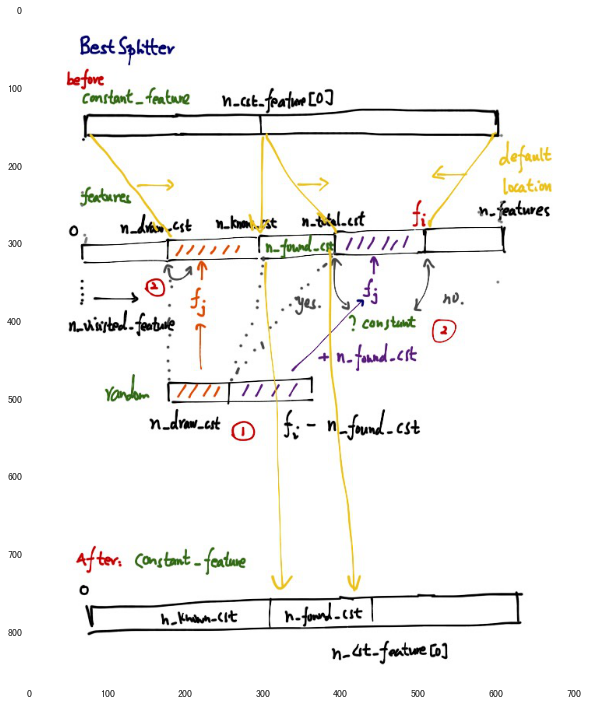

In [6]:
show_image("./res/BestSplitter.jpg", figsize=(10,15))

在找到最佳分割点后，剩下的就是善后工作。

1. 按分割点进行节点分割。
   
   ```Python
 471         # Reorganize into samples[start:best.pos] + samples[best.pos:end]
 472         if best.pos < end:
 473             feature_offset = X_feature_stride * best.feature
 474             partition_end = end
 475             p = start
 476
 477             while p < partition_end:
 478                 if X[X_sample_stride * samples[p] + feature_offset] <= best.threshold:
 479                     p += 1
 480
 481                 else:
 482                     partition_end -= 1
 483
 484                     tmp = samples[partition_end]
 485                     samples[partition_end] = samples[p]
 486                     samples[p] = tmp
 487
 488             self.criterion.reset()
 489             self.criterion.update(best.pos)
 490             best.improvement = self.criterion.impurity_improvement(impurity)
 491             self.criterion.children_impurity(&best.impurity_left,
 492                                              &best.impurity_right)
 493
   ```
   
2. 复制常数特征信息，确保 `features` 和 `constant_features` 一致。
   ```Python
 494         # Reset sample mask
 495 #+--  3 lines: if self.presort == 1:--------------------------------------------------------
 498
 499         # Respect invariant for constant features: the original order of
 500         # element in features[:n_known_constants] must be preserved for sibling
 501         # and child nodes
 502         memcpy(features, constant_features, sizeof(SIZE_t) * n_known_constants)
 503
 504         # Copy newly found constant features
 505         memcpy(constant_features + n_known_constants,
 506                features + n_known_constants,
 507                sizeof(SIZE_t) * n_found_constants)
 508
   ```
   
3. 返值。
   
   ```Python
 509         # Return values
 510         split[0] = best
 511         n_constant_features[0] = n_total_constants
   ```
   
   
附：这里特征值排序的算法，有机会再补充。

#### 2.2 RandomSplitter
RandomSplitter 和 BestSplitter 大同小异，主要的差异是对分割阈值的寻找。BestSplitter 会遍历所有的特征值来确定最好的阈值点，而 RandomSplitter 则是找出此特征最大徝和最小值，在这个范围内随机抽值作为阈值点，这种分割比较随缘。

差异的代码如下，就不多说了：

```Python
 726                 # Find min, max
 727                 min_feature_value = X[X_sample_stride * samples[start] + feature_stride]
 728                 max_feature_value = min_feature_value
 729                 Xf[start] = min_feature_value
 730
 731                 for p in range(start + 1, end):
 732 #+--  7 lines: current_feature_value = X[X_sample_stride * samples[p] + feature_stride]----- 739
 740                 if max_feature_value <= min_feature_value + FEATURE_THRESHOLD:
 741 #+--  6 lines: features[f_j] = features[n_total_constants]----------------------------------
 747                 else:
 748                     f_i -= 1
 749                     features[f_i], features[f_j] = features[f_j], features[f_i]
 750
 751                     # Draw a random threshold
 752                     current.threshold = rand_uniform(min_feature_value,
 753                                                      max_feature_value,
 754                                                      random_state)
```

### 3. 稀疏阵分割

#### 3.0 BaseSparseSplitter

稀疏阵与实阵的算法思路和流程是近乎一致的，差别是在对数据查找和分割的操作上。这里不再叙述，以后有机会接触到稀疏阵时，再说明。

### 总结

本文介绍了 BestSplit 和 RandomSplit 两种分割方法。